In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal
import os
import xarray as xr
import pickle
from netCDF4 import Dataset

In [2]:
#create dictionary
dataDict = {}

#names of simulations
name_list = ['az','sg', 'lc', 'na']

#create parameter list
parameters = [
"topographic__elevation",
"soil__depth",
"sediment__flux",
"landform__ID",
"precipitation",
"landform__ID",
"erosion__rate",
"vegetation__density",
'slope_degrees',
'tree_fpc',
'grass_fpc',
'shrub_fpc'
]

for name in name_list:
    dataDict[name] = {}
    for p in parameters:
        dataDict[name][p] = []

path = '/home/mschmid/Desktop/Paper_2_analysis/results/paper_2_results/coupled_vegi_precip/higher_K/'
path_to_output = '/ll_output/NC'

path_list = []
for name in name_list:
    path_list.append(os.path.join(path + name + path_to_output))
    
    
elapsed_time_start = 4900000
elapsed_time_end   = 4923000
dt                 = 100
output_start       = 49000
output_end         = 49230
output_array       = np.arange(output_start, output_end, 1)
elapsed_time_array = np.arange(elapsed_time_start, elapsed_time_end, dt)

counter = 0
for name,simu in zip(name_list,path_list):
    for elapsed, output in zip(elapsed_time_array, output_array):

        nc_file_path = os.path.join(simu + f'/output{elapsed}__{output}.nc')
        _dataDump = Dataset(nc_file_path)
        counter += 1

        if counter % 100 == 0:
            print('100 files done')


        for p in parameters:
            _cutDump = _dataDump.variables[p][:][0]
            #delete boundary nodes
            _cutDump = np.delete(_cutDump, 0 , axis = 0) 
            _cutDump = np.delete(_cutDump,-1 , axis = 0)
            _cutDump = np.delete(_cutDump, 0 , axis = 1)
            _cutDump = np.delete(_cutDump,-1 , axis = 1)

            dataDict[name][p].append(_cutDump)


        #print(f'output{elapsed}__{output}.nc')
        
print('All done.')

100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
All done.


In [3]:
area = 'az'

length_of_dataseries = np.shape(dataDict[area]['erosion__rate'])[0]

#create needed datasave-arrays
top_indicies    = np.zeros(length_of_dataseries)
slope_indicies  = np.zeros(length_of_dataseries)
flat_indicies   = np.zeros(length_of_dataseries)
valley_indicies = np.zeros(length_of_dataseries)

#erosion
top_erosion     = np.zeros(length_of_dataseries)
slope_erosion   = np.zeros(length_of_dataseries)
flat_erosion    = np.zeros(length_of_dataseries)
valley_erosion  = np.zeros(length_of_dataseries)

#trees
top_trees       = np.zeros(length_of_dataseries)
slope_trees     = np.zeros(length_of_dataseries)
flat_trees      = np.zeros(length_of_dataseries)
valley_trees    = np.zeros(length_of_dataseries)

#shrubs
top_shrubs      = np.zeros(length_of_dataseries)
slope_shrubs    = np.zeros(length_of_dataseries)
flat_shrubs     = np.zeros(length_of_dataseries)
valley_shrubs   = np.zeros(length_of_dataseries)

#grass
top_grass       = np.zeros(length_of_dataseries)
slope_grass     = np.zeros(length_of_dataseries)
flat_grass      = np.zeros(length_of_dataseries)
valley_grass    = np.zeros(length_of_dataseries)

#soil
top_soil        = np.zeros(length_of_dataseries)
slope_soil      = np.zeros(length_of_dataseries)
flat_soil       = np.zeros(length_of_dataseries)
valley_soil     = np.zeros(length_of_dataseries)

#rain
top_rain        = np.zeros(length_of_dataseries)
slope_rain      = np.zeros(length_of_dataseries)
flat_rain       = np.zeros(length_of_dataseries)
valley_rain     = np.zeros(length_of_dataseries)

#soil
top_soil        = np.zeros(length_of_dataseries)
slope_soil      = np.zeros(length_of_dataseries)
flat_soil       = np.zeros(length_of_dataseries)
valley_soil     = np.zeros(length_of_dataseries)

#sediment 
top_sedi        = np.zeros(length_of_dataseries)
slope_sedi      = np.zeros(length_of_dataseries)
flat_sedi       = np.zeros(length_of_dataseries)
valley_sedi     = np.zeros(length_of_dataseries)

'''
Create a masked array for all each of the possible TPI-Classification 
and calculate the mean for it.
'''

counter = 0

for eros, landform, trees, grass, shrubs, rain, soil, sediment in zip(
                                dataDict[area]['erosion__rate'], dataDict[area]['landform__ID'],
                                dataDict[area]['tree_fpc'], dataDict[area]['grass_fpc'],
                                dataDict[area]['shrub_fpc'], dataDict[area]['precipitation'], 
                                dataDict[area]['soil__depth'], dataDict[area]['sediment__flux']):
    
    _landform_matrix = np.array(landform.flatten())
    _erosion_matrix  = np.array(eros.flatten())
    _tree_matrix     = np.array(trees.flatten())
    _grass_matrix    = np.array(grass.flatten())
    _shrub_matrix    = np.array(shrubs.flatten())
    _rain_matrix     = np.array(rain.flatten())
    _soil_matrix     = np.array(soil.flatten())
    _sedi_matrix     = np.array(sediment.flatten())
    
    landform_matrix = [str(int(lf)) for lf in _landform_matrix]
    landform_matrix = np.array(landform_matrix)
    
    for lf in np.unique(landform_matrix):
        lf = str(int(lf))
        if lf[-2] == '1':
            #top
            #extract indicies
            _top_indicies = np.array(np.where(landform_matrix == lf))
            top_indicies = np.append(top_indicies, _top_indicies)
            top_indicies = [int(ind) for ind in top_indicies]
            
            #append mean values
            top_erosion[counter] = np.mean(_erosion_matrix[top_indicies])
            top_trees[counter]   = np.mean(_tree_matrix[top_indicies])
            top_shrubs[counter]  = np.mean(_shrub_matrix[top_indicies])
            top_grass[counter]   = np.mean(_grass_matrix[top_indicies])
            top_rain[counter]    = np.mean(_rain_matrix[top_indicies])
            top_soil[counter]    = np.mean(_soil_matrix[top_indicies])
            top_sedi[counter]    = np.mean(_sedi_matrix[top_indicies])
            
        elif lf[-2] == '3':
            #slope
            #extract indicies
            _slope_indicies = np.array(np.where(landform_matrix == lf))
            slope_indicies = np.append(slope_indicies, _slope_indicies)
            slope_indicies = [int(ind) for ind in slope_indicies]
            
            #append mean values
            slope_erosion[counter] = np.mean(_erosion_matrix[slope_indicies])
            slope_trees[counter]   = np.mean(_tree_matrix[slope_indicies])
            slope_shrubs[counter]  = np.mean(_shrub_matrix[slope_indicies])
            slope_grass[counter]   = np.mean(_grass_matrix[slope_indicies])
            slope_rain[counter]    = np.mean(_rain_matrix[slope_indicies])
            slope_soil[counter]    = np.mean(_soil_matrix[slope_indicies])
            slope_sedi[counter]    = np.mean(_sedi_matrix[slope_indicies])
        
        elif lf[-2] == '4':
            #flat
            #extract indicies
            _flat_indicies = np.array(np.where(landform_matrix == lf))
            flat_indicies = np.append(flat_indicies, _flat_indicies)
            flat_indicies = [int(ind) for ind in flat_indicies]
            
            #append mean values
            flat_erosion[counter] = np.mean(_erosion_matrix[flat_indicies])
            flat_trees[counter]   = np.mean(_tree_matrix[flat_indicies])
            flat_shrubs[counter]  = np.mean(_shrub_matrix[flat_indicies])
            flat_grass[counter]   = np.mean(_grass_matrix[flat_indicies])
            flat_rain[counter]    = np.mean(_rain_matrix[flat_indicies])
            flat_soil[counter]    = np.mean(_soil_matrix[flat_indicies])
            flat_sedi[counter]    = np.mean(_sedi_matrix[flat_indicies])
        
        elif lf[-2] == '6':
            #valley
            #extract indicies
            _valley_indicies = np.array(np.where(landform_matrix == lf))
            valley_indicies = np.append(valley_indicies, _valley_indicies)
            valley_indicies = [int(ind) for ind in valley_indicies]
            
            #append mean values
            valley_erosion[counter] = np.mean(_erosion_matrix[valley_indicies])
            valley_trees[counter]   = np.mean(_tree_matrix[valley_indicies])
            valley_shrubs[counter]  = np.mean(_shrub_matrix[valley_indicies])
            valley_grass[counter]   = np.mean(_grass_matrix[valley_indicies])
            valley_rain[counter]    = np.mean(_rain_matrix[valley_indicies])
            valley_soil[counter]    = np.mean(_soil_matrix[valley_indicies])
            valley_sedi[counter]    = np.mean(_sedi_matrix[valley_indicies])
            
        else: 
            print('There was no matching landform')
            
    counter += 1

time_vector    = np.arange(0, np.shape(top_erosion)[0] * 100, 100)
print('all done')

all done


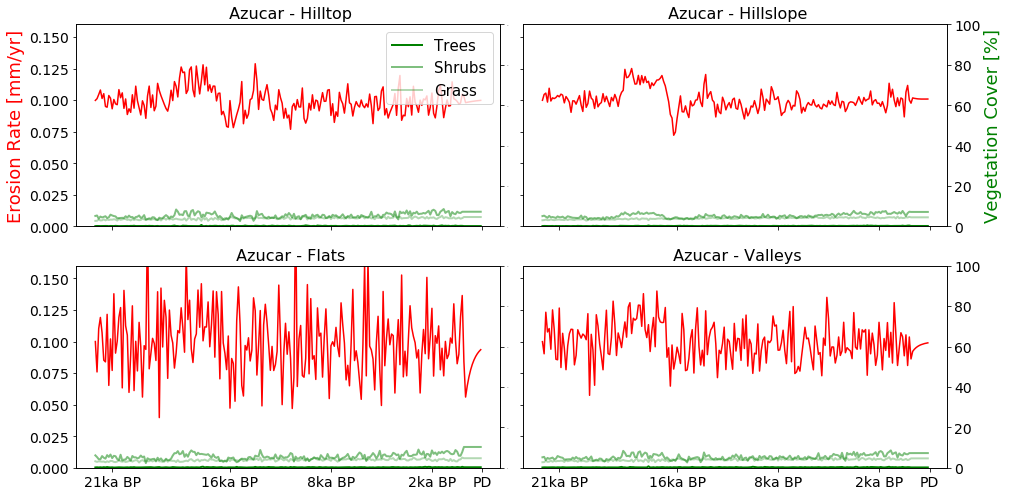

In [4]:
fig, ax = plt.subplots(nrows = 2, 
                      ncols = 2, 
                      figsize = [14,7], 
                      sharex = True, 
                      sharey = True)

label_fontsize = 18
title_fontsize = 16
ticks_fontsize = 14
legend_fontsize = 10

y_upper_limit = 0.

#top left
ax[0,0].set_title(' Azucar - Hilltop', fontsize = title_fontsize)
ax[0,0].plot(time_vector, top_erosion * 1000, 'r')

ax00 = ax[0,0].twinx()
ax00.plot(time_vector, top_trees  * 100, 'g', label = 'Trees' , linewidth = 2, alpha = 1)
ax00.plot(time_vector, top_shrubs * 100, 'g', label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax00.plot(time_vector, top_grass  * 100, 'g', label = 'Grass' , linewidth = 2, alpha = 0.3)

#top right
ax[0,1].set_title(' Azucar - Hillslope', fontsize = title_fontsize)
ax[0,1].plot(time_vector, slope_erosion * 1000, 'r')

ax01 = ax[0,1].twinx()
ax01.plot(time_vector, slope_trees  * 100, 'g',   label = 'Trees',  linewidth = 2, alpha = 1)
ax01.plot(time_vector, slope_shrubs * 100, 'g',   label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax01.plot(time_vector, slope_grass  * 100, 'g',   label = 'Grass',  linewidth = 2, alpha = 0.3)

#lower left
ax[1,0].set_title(' Azucar - Flats', fontsize = title_fontsize)
ax[1,0].plot(time_vector, flat_erosion * 1000, 'r')

ax10 = ax[1,0].twinx()
ax10.plot(time_vector, flat_trees  * 100, 'g',  label = 'Trees',  linewidth = 2, alpha = 1)
ax10.plot(time_vector, flat_shrubs * 100, 'g',  label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax10.plot(time_vector, flat_grass  * 100, 'g',  label = 'Grass',  linewidth = 2, alpha = 0.3)

#lower right
ax[1,1].set_title(' Azucar - Valleys', fontsize = title_fontsize)
ax[1,1].plot(time_vector, valley_erosion * 1000, 'r')

ax11 = ax[1,1].twinx()
ax11.plot(time_vector, top_trees  * 100, 'g', label = 'Trees',  linewidth = 2, alpha = 1)
ax11.plot(time_vector, top_shrubs * 100, 'g', label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax11.plot(time_vector, top_grass  * 100, 'g', label = 'Grass',  linewidth = 2, alpha = 0.3)

#FORMATTING
#tickparameters for primary axes
for axs in ax.flatten():
    axs.set_ylim(0, 0.16)
    axs.axes.tick_params(labelsize = ticks_fontsize)   
#secondary axes
ax00.set_ylim(0,100)
ax01.set_ylim(0,100)
ax10.set_ylim(0,100)
ax11.set_ylim(0,100)
ax00.axes.tick_params(labelsize = 0)
ax01.axes.tick_params(labelsize = ticks_fontsize)
ax10.axes.tick_params(labelsize = 0)
ax11.axes.tick_params(labelsize = ticks_fontsize)

#ylabels
ax[0,0].set_ylabel('Erosion Rate [mm/yr]', fontsize = label_fontsize, color = 'red')
ax01.set_ylabel('Vegetation Cover [%]', fontsize = label_fontsize, color = 'green')

#xlabels
x1 = [1000, 8000, 14000, 20000, 23000]
labels = ['21ka BP','16ka BP','8ka BP','2ka BP', 'PD']
ax[0,0].set_xticks(x1)
ax[0,0].set_xticklabels(labels)

#legend
ax00.legend(fontsize = 15)

plt.tight_layout()

plt.savefig('azucar_erosion_rate_per_tpi.png')

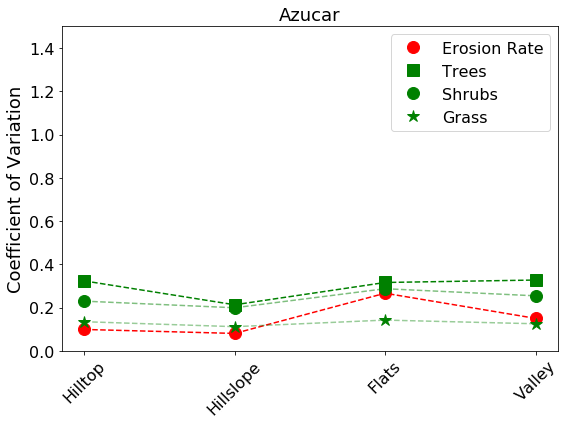

In [5]:
from scipy.stats import variation

ax1 = [0,1,2,3]
ax1_labels = ['Hilltop', 'Hillslope', 'Flats', 'Valley']

fig, ax = plt.subplots(1, 
                      figsize = [8,6])

#Erosion
ax.plot(ax1, 
       [variation(top_erosion), variation(slope_erosion), variation(flat_erosion), variation(valley_erosion)], 'r--')
ax.plot(ax1, 
       [variation(top_erosion), variation(slope_erosion), variation(flat_erosion), variation(valley_erosion)], 'ro', markersize = 12, label = 'Erosion Rate')

#Trees
ax.plot(ax1, 
       [variation(top_trees), variation(slope_trees), variation(flat_trees), variation(valley_trees)], 'g--', alpha = 1)
ax.plot(ax1, 
       [variation(top_trees), variation(slope_trees), variation(flat_trees), variation(valley_trees)], 'gs', markersize = 12, label = 'Trees')

#Shrubs
ax.plot(ax1, 
       [variation(top_shrubs), variation(slope_shrubs), variation(flat_shrubs), variation(valley_shrubs)], 'g--', alpha = 0.5)
ax.plot(ax1, 
       [variation(top_shrubs), variation(slope_shrubs), variation(flat_shrubs), variation(valley_shrubs)], 'go', markersize = 12, label = 'Shrubs')

#Grass
ax.plot(ax1, 
       [variation(top_grass), variation(slope_grass), variation(flat_grass), variation(valley_grass)], 'g--', alpha = 0.4)
ax.plot(ax1, 
       [variation(top_grass), variation(slope_grass), variation(flat_grass), variation(valley_grass)], 'g*', markersize = 12, label = 'Grass')

ax.legend(fontsize = 16)

ax.set_title('Azucar', fontsize = 18)
ax.set_ylabel('Coefficient of Variation', fontsize = 18)
ax.set_xticks(ax1)
ax.set_xticklabels(ax1_labels, rotation = 45)
ax.set_ylim(0,1.5)
ax.axes.tick_params(labelsize = 16)
plt.tight_layout()
plt.savefig('azucar_coefficient_of_Variation.png')

In [6]:
area = 'sg'

length_of_dataseries = np.shape(dataDict[area]['erosion__rate'])[0]

#create needed datasave-arrays
top_indicies    = np.zeros(length_of_dataseries)
slope_indicies  = np.zeros(length_of_dataseries)
flat_indicies   = np.zeros(length_of_dataseries)
valley_indicies = np.zeros(length_of_dataseries)

#erosion
top_erosion     = np.zeros(length_of_dataseries)
slope_erosion   = np.zeros(length_of_dataseries)
flat_erosion    = np.zeros(length_of_dataseries)
valley_erosion  = np.zeros(length_of_dataseries)

#trees
top_trees       = np.zeros(length_of_dataseries)
slope_trees     = np.zeros(length_of_dataseries)
flat_trees      = np.zeros(length_of_dataseries)
valley_trees    = np.zeros(length_of_dataseries)

#shrubs
top_shrubs      = np.zeros(length_of_dataseries)
slope_shrubs    = np.zeros(length_of_dataseries)
flat_shrubs     = np.zeros(length_of_dataseries)
valley_shrubs   = np.zeros(length_of_dataseries)

#grass
top_grass       = np.zeros(length_of_dataseries)
slope_grass     = np.zeros(length_of_dataseries)
flat_grass      = np.zeros(length_of_dataseries)
valley_grass    = np.zeros(length_of_dataseries)

#soil
top_soil        = np.zeros(length_of_dataseries)
slope_soil      = np.zeros(length_of_dataseries)
flat_soil       = np.zeros(length_of_dataseries)
valley_soil     = np.zeros(length_of_dataseries)

#rain
top_rain        = np.zeros(length_of_dataseries)
slope_rain      = np.zeros(length_of_dataseries)
flat_rain       = np.zeros(length_of_dataseries)
valley_rain     = np.zeros(length_of_dataseries)

#soil
top_soil        = np.zeros(length_of_dataseries)
slope_soil      = np.zeros(length_of_dataseries)
flat_soil       = np.zeros(length_of_dataseries)
valley_soil     = np.zeros(length_of_dataseries)

#sediment 
top_sedi        = np.zeros(length_of_dataseries)
slope_sedi      = np.zeros(length_of_dataseries)
flat_sedi       = np.zeros(length_of_dataseries)
valley_sedi     = np.zeros(length_of_dataseries)

'''
Create a masked array for all each of the possible TPI-Classification 
and calculate the mean for it.
'''

counter = 0

for eros, landform, trees, grass, shrubs, rain, soil, sediment in zip(
                                dataDict[area]['erosion__rate'], dataDict[area]['landform__ID'],
                                dataDict[area]['tree_fpc'], dataDict[area]['grass_fpc'],
                                dataDict[area]['shrub_fpc'], dataDict[area]['precipitation'], 
                                dataDict[area]['soil__depth'], dataDict[area]['sediment__flux']):
    
    _landform_matrix = np.array(landform.flatten())
    _erosion_matrix  = np.array(eros.flatten())
    _tree_matrix     = np.array(trees.flatten())
    _grass_matrix    = np.array(grass.flatten())
    _shrub_matrix    = np.array(shrubs.flatten())
    _rain_matrix     = np.array(rain.flatten())
    _soil_matrix     = np.array(soil.flatten())
    _sedi_matrix     = np.array(sediment.flatten())
    
    landform_matrix = [str(int(lf)) for lf in _landform_matrix]
    landform_matrix = np.array(landform_matrix)
    
    for lf in np.unique(landform_matrix):
        lf = str(int(lf))
        if lf[-2] == '1':
            #top
            #extract indicies
            _top_indicies = np.array(np.where(landform_matrix == lf))
            top_indicies = np.append(top_indicies, _top_indicies)
            top_indicies = [int(ind) for ind in top_indicies]
            
            #append mean values
            top_erosion[counter] = np.mean(_erosion_matrix[top_indicies])
            top_trees[counter]   = np.mean(_tree_matrix[top_indicies])
            top_shrubs[counter]  = np.mean(_shrub_matrix[top_indicies])
            top_grass[counter]   = np.mean(_grass_matrix[top_indicies])
            top_rain[counter]    = np.mean(_rain_matrix[top_indicies])
            top_soil[counter]    = np.mean(_soil_matrix[top_indicies])
            top_sedi[counter]    = np.mean(_sedi_matrix[top_indicies])
            
        elif lf[-2] == '3':
            #slope
            #extract indicies
            _slope_indicies = np.array(np.where(landform_matrix == lf))
            slope_indicies = np.append(slope_indicies, _slope_indicies)
            slope_indicies = [int(ind) for ind in slope_indicies]
            
            #append mean values
            slope_erosion[counter] = np.mean(_erosion_matrix[slope_indicies])
            slope_trees[counter]   = np.mean(_tree_matrix[slope_indicies])
            slope_shrubs[counter]  = np.mean(_shrub_matrix[slope_indicies])
            slope_grass[counter]   = np.mean(_grass_matrix[slope_indicies])
            slope_rain[counter]    = np.mean(_rain_matrix[slope_indicies])
            slope_soil[counter]    = np.mean(_soil_matrix[slope_indicies])
            slope_sedi[counter]    = np.mean(_sedi_matrix[slope_indicies])
        
        elif lf[-2] == '4':
            #flat
            #extract indicies
            _flat_indicies = np.array(np.where(landform_matrix == lf))
            flat_indicies = np.append(flat_indicies, _flat_indicies)
            flat_indicies = [int(ind) for ind in flat_indicies]
            
            #append mean values
            flat_erosion[counter] = np.mean(_erosion_matrix[flat_indicies])
            flat_trees[counter]   = np.mean(_tree_matrix[flat_indicies])
            flat_shrubs[counter]  = np.mean(_shrub_matrix[flat_indicies])
            flat_grass[counter]   = np.mean(_grass_matrix[flat_indicies])
            flat_rain[counter]    = np.mean(_rain_matrix[flat_indicies])
            flat_soil[counter]    = np.mean(_soil_matrix[flat_indicies])
            flat_sedi[counter]    = np.mean(_sedi_matrix[flat_indicies])
        
        elif lf[-2] == '6':
            #valley
            #extract indicies
            _valley_indicies = np.array(np.where(landform_matrix == lf))
            valley_indicies = np.append(valley_indicies, _valley_indicies)
            valley_indicies = [int(ind) for ind in valley_indicies]
            
            #append mean values
            valley_erosion[counter] = np.mean(_erosion_matrix[valley_indicies])
            valley_trees[counter]   = np.mean(_tree_matrix[valley_indicies])
            valley_shrubs[counter]  = np.mean(_shrub_matrix[valley_indicies])
            valley_grass[counter]   = np.mean(_grass_matrix[valley_indicies])
            valley_rain[counter]    = np.mean(_rain_matrix[valley_indicies])
            valley_soil[counter]    = np.mean(_soil_matrix[valley_indicies])
            valley_sedi[counter]    = np.mean(_sedi_matrix[valley_indicies])
            
        else: 
            print('There was no matching landform')
            
    counter += 1

time_vector    = np.arange(0, np.shape(top_erosion)[0] * 100, 100)
print('all done')

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
fig, ax = plt.subplots(nrows = 2, 
                      ncols = 2, 
                      figsize = [14,7], 
                      sharex = True, 
                      sharey = True)

label_fontsize = 18
title_fontsize = 16
ticks_fontsize = 14
legend_fontsize = 10

y_upper_limit = 0.

#top left
ax[0,0].set_title('Santa Gracia - Hilltop', fontsize = title_fontsize)
ax[0,0].plot(time_vector, top_erosion * 1000, 'r')

ax00 = ax[0,0].twinx()
ax00.plot(time_vector, top_trees  * 100, 'g', label = 'Trees' , linewidth = 2, alpha = 1)
ax00.plot(time_vector, top_shrubs * 100, 'g', label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax00.plot(time_vector, top_grass  * 100, 'g', label = 'Grass' , linewidth = 2, alpha = 0.3)

#top right
ax[0,1].set_title('Santa Gracia - Hillslope', fontsize = title_fontsize)
ax[0,1].plot(time_vector, slope_erosion * 1000, 'r')

ax01 = ax[0,1].twinx()
ax01.plot(time_vector, slope_trees  * 100, 'g',   label = 'Trees',  linewidth = 2, alpha = 1)
ax01.plot(time_vector, slope_shrubs * 100, 'g',   label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax01.plot(time_vector, slope_grass  * 100, 'g',   label = 'Grass',  linewidth = 2, alpha = 0.3)

#lower left
ax[1,0].set_title('Santa Gracia - Flats', fontsize = title_fontsize)
ax[1,0].plot(time_vector, flat_erosion * 1000, 'r')

ax10 = ax[1,0].twinx()
ax10.plot(time_vector, flat_trees  * 100, 'g',  label = 'Trees',  linewidth = 2, alpha = 1)
ax10.plot(time_vector, flat_shrubs * 100, 'g',  label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax10.plot(time_vector, flat_grass  * 100, 'g',  label = 'Grass',  linewidth = 2, alpha = 0.3)

#lower right
ax[1,1].set_title('Santa Gracia - Valleys', fontsize = title_fontsize)
ax[1,1].plot(time_vector, valley_erosion * 1000, 'r')

ax11 = ax[1,1].twinx()
ax11.plot(time_vector, top_trees  * 100, 'g', label = 'Trees',  linewidth = 2, alpha = 1)
ax11.plot(time_vector, top_shrubs * 100, 'g', label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax11.plot(time_vector, top_grass  * 100, 'g', label = 'Grass',  linewidth = 2, alpha = 0.3)

#FORMATTING
#tickparameters for primary axes
for axs in ax.flatten():
    axs.set_ylim(0, 0.16)
    axs.axes.tick_params(labelsize = ticks_fontsize)   
#secondary axes
ax00.set_ylim(0,100)
ax01.set_ylim(0,100)
ax10.set_ylim(0,100)
ax11.set_ylim(0,100)
ax00.axes.tick_params(labelsize = 0)
ax01.axes.tick_params(labelsize = ticks_fontsize)
ax10.axes.tick_params(labelsize = 0)
ax11.axes.tick_params(labelsize = ticks_fontsize)

#ylabels
ax[0,0].set_ylabel('Erosion Rate [mm/yr]', fontsize = label_fontsize, color = 'red')
ax01.set_ylabel('Vegetation Cover [%]', fontsize = label_fontsize, color = 'green')

#xlabels
x1 = [1000, 8000, 14000, 20000, 23000]
labels = ['21ka BP','16ka BP','8ka BP','2ka BP', 'PD']
ax[0,0].set_xticks(x1)
ax[0,0].set_xticklabels(labels)

#legend
ax00.legend(fontsize = 15)

plt.tight_layout()

plt.savefig('santa_gracia_erosion_rate_per_tpi.png')

In [ ]:
from scipy.stats import variation

ax1 = [0,1,2,3]
ax1_labels = ['Hilltop', 'Hillslope', 'Flats', 'Valley']

fig, ax = plt.subplots(1, 
                      figsize = [8,6])

#Erosion
ax.plot(ax1, 
       [variation(top_erosion), variation(slope_erosion), variation(flat_erosion), variation(valley_erosion)], 'r--')
ax.plot(ax1, 
       [variation(top_erosion), variation(slope_erosion), variation(flat_erosion), variation(valley_erosion)], 'ro', markersize = 12, label = 'Erosion Rate')

#Trees
ax.plot(ax1, 
       [variation(top_trees), variation(slope_trees), variation(flat_trees), variation(valley_trees)], 'g--', alpha = 1)
ax.plot(ax1, 
       [variation(top_trees), variation(slope_trees), variation(flat_trees), variation(valley_trees)], 'gs', markersize = 12, label = 'Trees')

#Shrubs
ax.plot(ax1, 
       [variation(top_shrubs), variation(slope_shrubs), variation(flat_shrubs), variation(valley_shrubs)], 'g--', alpha = 0.5)
ax.plot(ax1, 
       [variation(top_shrubs), variation(slope_shrubs), variation(flat_shrubs), variation(valley_shrubs)], 'go', markersize = 12, label = 'Shrubs')

#Grass
ax.plot(ax1, 
       [variation(top_grass), variation(slope_grass), variation(flat_grass), variation(valley_grass)], 'g--', alpha = 0.4)
ax.plot(ax1, 
       [variation(top_grass), variation(slope_grass), variation(flat_grass), variation(valley_grass)], 'g*', markersize = 12, label = 'Grass')

ax.legend(fontsize = 16)

ax.set_title('Santa Gracia', fontsize = 18)
ax.set_ylabel('Coefficient of Variation', fontsize = 18)
ax.set_xticks(ax1)
ax.set_xticklabels(ax1_labels, rotation = 45)
ax.axes.tick_params(labelsize = 16)
ax.set_ylim(0,1.5)
plt.tight_layout()
plt.savefig('santa_gracia_coefficient_of_Variation.png')

In [ ]:
area = 'lc'

length_of_dataseries = np.shape(dataDict[area]['erosion__rate'])[0]

#create needed datasave-arrays
top_indicies    = np.zeros(length_of_dataseries)
slope_indicies  = np.zeros(length_of_dataseries)
flat_indicies   = np.zeros(length_of_dataseries)
valley_indicies = np.zeros(length_of_dataseries)

#erosion
top_erosion     = np.zeros(length_of_dataseries)
slope_erosion   = np.zeros(length_of_dataseries)
flat_erosion    = np.zeros(length_of_dataseries)
valley_erosion  = np.zeros(length_of_dataseries)

#trees
top_trees       = np.zeros(length_of_dataseries)
slope_trees     = np.zeros(length_of_dataseries)
flat_trees      = np.zeros(length_of_dataseries)
valley_trees    = np.zeros(length_of_dataseries)

#shrubs
top_shrubs      = np.zeros(length_of_dataseries)
slope_shrubs    = np.zeros(length_of_dataseries)
flat_shrubs     = np.zeros(length_of_dataseries)
valley_shrubs   = np.zeros(length_of_dataseries)

#grass
top_grass       = np.zeros(length_of_dataseries)
slope_grass     = np.zeros(length_of_dataseries)
flat_grass      = np.zeros(length_of_dataseries)
valley_grass    = np.zeros(length_of_dataseries)

#soil
top_soil        = np.zeros(length_of_dataseries)
slope_soil      = np.zeros(length_of_dataseries)
flat_soil       = np.zeros(length_of_dataseries)
valley_soil     = np.zeros(length_of_dataseries)

#rain
top_rain        = np.zeros(length_of_dataseries)
slope_rain      = np.zeros(length_of_dataseries)
flat_rain       = np.zeros(length_of_dataseries)
valley_rain     = np.zeros(length_of_dataseries)

#soil
top_soil        = np.zeros(length_of_dataseries)
slope_soil      = np.zeros(length_of_dataseries)
flat_soil       = np.zeros(length_of_dataseries)
valley_soil     = np.zeros(length_of_dataseries)

#sediment 
top_sedi        = np.zeros(length_of_dataseries)
slope_sedi      = np.zeros(length_of_dataseries)
flat_sedi       = np.zeros(length_of_dataseries)
valley_sedi     = np.zeros(length_of_dataseries)

'''
Create a masked array for all each of the possible TPI-Classification 
and calculate the mean for it.
'''

counter = 0

for eros, landform, trees, grass, shrubs, rain, soil, sediment in zip(
                                dataDict[area]['erosion__rate'], dataDict[area]['landform__ID'],
                                dataDict[area]['tree_fpc'], dataDict[area]['grass_fpc'],
                                dataDict[area]['shrub_fpc'], dataDict[area]['precipitation'], 
                                dataDict[area]['soil__depth'], dataDict[area]['sediment__flux']):
    
    _landform_matrix = np.array(landform.flatten())
    _erosion_matrix  = np.array(eros.flatten())
    _tree_matrix     = np.array(trees.flatten())
    _grass_matrix    = np.array(grass.flatten())
    _shrub_matrix    = np.array(shrubs.flatten())
    _rain_matrix     = np.array(rain.flatten())
    _soil_matrix     = np.array(soil.flatten())
    _sedi_matrix     = np.array(sediment.flatten())
    
    landform_matrix = [str(int(lf)) for lf in _landform_matrix]
    landform_matrix = np.array(landform_matrix)
    
    for lf in np.unique(landform_matrix):
        lf = str(int(lf))
        if lf[-2] == '1':
            #top
            #extract indicies
            _top_indicies = np.array(np.where(landform_matrix == lf))
            top_indicies = np.append(top_indicies, _top_indicies)
            top_indicies = [int(ind) for ind in top_indicies]
            
            #append mean values
            top_erosion[counter] = np.mean(_erosion_matrix[top_indicies])
            top_trees[counter]   = np.mean(_tree_matrix[top_indicies])
            top_shrubs[counter]  = np.mean(_shrub_matrix[top_indicies])
            top_grass[counter]   = np.mean(_grass_matrix[top_indicies])
            top_rain[counter]    = np.mean(_rain_matrix[top_indicies])
            top_soil[counter]    = np.mean(_soil_matrix[top_indicies])
            top_sedi[counter]    = np.mean(_sedi_matrix[top_indicies])
            
        elif lf[-2] == '3':
            #slope
            #extract indicies
            _slope_indicies = np.array(np.where(landform_matrix == lf))
            slope_indicies = np.append(slope_indicies, _slope_indicies)
            slope_indicies = [int(ind) for ind in slope_indicies]
            
            #append mean values
            slope_erosion[counter] = np.mean(_erosion_matrix[slope_indicies])
            slope_trees[counter]   = np.mean(_tree_matrix[slope_indicies])
            slope_shrubs[counter]  = np.mean(_shrub_matrix[slope_indicies])
            slope_grass[counter]   = np.mean(_grass_matrix[slope_indicies])
            slope_rain[counter]    = np.mean(_rain_matrix[slope_indicies])
            slope_soil[counter]    = np.mean(_soil_matrix[slope_indicies])
            slope_sedi[counter]    = np.mean(_sedi_matrix[slope_indicies])
        
        elif lf[-2] == '4':
            #flat
            #extract indicies
            _flat_indicies = np.array(np.where(landform_matrix == lf))
            flat_indicies = np.append(flat_indicies, _flat_indicies)
            flat_indicies = [int(ind) for ind in flat_indicies]
            
            #append mean values
            flat_erosion[counter] = np.mean(_erosion_matrix[flat_indicies])
            flat_trees[counter]   = np.mean(_tree_matrix[flat_indicies])
            flat_shrubs[counter]  = np.mean(_shrub_matrix[flat_indicies])
            flat_grass[counter]   = np.mean(_grass_matrix[flat_indicies])
            flat_rain[counter]    = np.mean(_rain_matrix[flat_indicies])
            flat_soil[counter]    = np.mean(_soil_matrix[flat_indicies])
            flat_sedi[counter]    = np.mean(_sedi_matrix[flat_indicies])
        
        elif lf[-2] == '6':
            #valley
            #extract indicies
            _valley_indicies = np.array(np.where(landform_matrix == lf))
            valley_indicies = np.append(valley_indicies, _valley_indicies)
            valley_indicies = [int(ind) for ind in valley_indicies]
            
            #append mean values
            valley_erosion[counter] = np.mean(_erosion_matrix[valley_indicies])
            valley_trees[counter]   = np.mean(_tree_matrix[valley_indicies])
            valley_shrubs[counter]  = np.mean(_shrub_matrix[valley_indicies])
            valley_grass[counter]   = np.mean(_grass_matrix[valley_indicies])
            valley_rain[counter]    = np.mean(_rain_matrix[valley_indicies])
            valley_soil[counter]    = np.mean(_soil_matrix[valley_indicies])
            valley_sedi[counter]    = np.mean(_sedi_matrix[valley_indicies])
            
        else: 
            print('There was no matching landform')
            
    counter += 1

time_vector    = np.arange(0, np.shape(top_erosion)[0] * 100, 100)
print('all done')

In [ ]:
fig, ax = plt.subplots(nrows = 2, 
                      ncols = 2, 
                      figsize = [14,7], 
                      sharex = True, 
                      sharey = True)

label_fontsize = 18
title_fontsize = 16
ticks_fontsize = 14
legend_fontsize = 10

y_upper_limit = 0.

#top left
ax[0,0].set_title('La Campana - Hilltop', fontsize = title_fontsize)
ax[0,0].plot(time_vector, top_erosion * 1000, 'r')

ax00 = ax[0,0].twinx()
ax00.plot(time_vector, top_trees  * 100, 'g', label = 'Trees' , linewidth = 2, alpha = 1)
ax00.plot(time_vector, top_shrubs * 100, 'g', label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax00.plot(time_vector, top_grass  * 100, 'g', label = 'Grass' , linewidth = 2, alpha = 0.3)

#top right
ax[0,1].set_title('La Campana - Hillslope', fontsize = title_fontsize)
ax[0,1].plot(time_vector, slope_erosion * 1000, 'r')

ax01 = ax[0,1].twinx()
ax01.plot(time_vector, slope_trees  * 100, 'g',   label = 'Trees',  linewidth = 2, alpha = 1)
ax01.plot(time_vector, slope_shrubs * 100, 'g',   label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax01.plot(time_vector, slope_grass  * 100, 'g',   label = 'Grass',  linewidth = 2, alpha = 0.3)

#lower left
ax[1,0].set_title('La Campana - Flats', fontsize = title_fontsize)
ax[1,0].plot(time_vector, flat_erosion * 1000, 'r')

ax10 = ax[1,0].twinx()
ax10.plot(time_vector, flat_trees  * 100, 'g',  label = 'Trees',  linewidth = 2, alpha = 1)
ax10.plot(time_vector, flat_shrubs * 100, 'g',  label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax10.plot(time_vector, flat_grass  * 100, 'g',  label = 'Grass',  linewidth = 2, alpha = 0.3)

#lower right
ax[1,1].set_title('La Campana - Valleys', fontsize = title_fontsize)
ax[1,1].plot(time_vector, valley_erosion * 1000, 'r')

ax11 = ax[1,1].twinx()
ax11.plot(time_vector, top_trees  * 100, 'g', label = 'Trees',  linewidth = 2, alpha = 1)
ax11.plot(time_vector, top_shrubs * 100, 'g', label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax11.plot(time_vector, top_grass  * 100, 'g', label = 'Grass',  linewidth = 2, alpha = 0.3)

#FORMATTING
#tickparameters for primary axes
for axs in ax.flatten():
    axs.set_ylim(0, 0.16)
    axs.axes.tick_params(labelsize = ticks_fontsize)   
#secondary axes
ax00.set_ylim(0,100)
ax01.set_ylim(0,100)
ax10.set_ylim(0,100)
ax11.set_ylim(0,100)
ax00.axes.tick_params(labelsize = 0)
ax01.axes.tick_params(labelsize = ticks_fontsize)
ax10.axes.tick_params(labelsize = 0)
ax11.axes.tick_params(labelsize = ticks_fontsize)

#ylabels
ax[0,0].set_ylabel('Erosion Rate [mm/yr]', fontsize = label_fontsize, color = 'red')
ax01.set_ylabel('Vegetation Cover [%]', fontsize = label_fontsize, color = 'green')

#xlabels
x1 = [1000, 8000, 14000, 20000, 23000]
labels = ['21ka BP','16ka BP','8ka BP','2ka BP', 'PD']
ax[0,0].set_xticks(x1)
ax[0,0].set_xticklabels(labels)

#legend
ax00.legend(fontsize = 15)

plt.tight_layout()

plt.savefig('la_campana_erosion_rate_per_tpi.png')

In [ ]:
from scipy.stats import variation

ax1 = [0,1,2,3]
ax1_labels = ['Hilltop', 'Hillslope', 'Flats', 'Valley']

fig, ax = plt.subplots(1, 
                      figsize = [8,6])

#Erosion
ax.plot(ax1, 
       [variation(top_erosion), variation(slope_erosion), variation(flat_erosion), variation(valley_erosion)], 'r--')
ax.plot(ax1, 
       [variation(top_erosion), variation(slope_erosion), variation(flat_erosion), variation(valley_erosion)], 'ro', markersize = 12, label = 'Erosion Rate')

#Trees
ax.plot(ax1, 
       [variation(top_trees), variation(slope_trees), variation(flat_trees), variation(valley_trees)], 'g--', alpha = 1)
ax.plot(ax1, 
       [variation(top_trees), variation(slope_trees), variation(flat_trees), variation(valley_trees)], 'gs', markersize = 12, label = 'Trees')

#Shrubs
ax.plot(ax1, 
       [variation(top_shrubs), variation(slope_shrubs), variation(flat_shrubs), variation(valley_shrubs)], 'g--', alpha = 0.5)
ax.plot(ax1, 
       [variation(top_shrubs), variation(slope_shrubs), variation(flat_shrubs), variation(valley_shrubs)], 'go', markersize = 12, label = 'Shrubs')

#Grass
ax.plot(ax1, 
       [variation(top_grass), variation(slope_grass), variation(flat_grass), variation(valley_grass)], 'g--', alpha = 0.4)
ax.plot(ax1, 
       [variation(top_grass), variation(slope_grass), variation(flat_grass), variation(valley_grass)], 'g*', markersize = 12, label = 'Grass')

ax.legend(fontsize = 16)

ax.set_title('La Campana', fontsize = 18)
ax.set_ylabel('Coefficient of Variation', fontsize = 18)
ax.set_xticks(ax1)
ax.set_xticklabels(ax1_labels, rotation = 45)
ax.axes.tick_params(labelsize = 16)
ax.set_ylim(0,1.5)
plt.tight_layout()
plt.savefig('la_campana_coefficient_of_Variation.png')

In [ ]:
area = 'na'

length_of_dataseries = np.shape(dataDict[area]['erosion__rate'])[0]

#create needed datasave-arrays
top_indicies    = np.zeros(length_of_dataseries)
slope_indicies  = np.zeros(length_of_dataseries)
flat_indicies   = np.zeros(length_of_dataseries)
valley_indicies = np.zeros(length_of_dataseries)

#erosion
top_erosion     = np.zeros(length_of_dataseries)
slope_erosion   = np.zeros(length_of_dataseries)
flat_erosion    = np.zeros(length_of_dataseries)
valley_erosion  = np.zeros(length_of_dataseries)

#trees
top_trees       = np.zeros(length_of_dataseries)
slope_trees     = np.zeros(length_of_dataseries)
flat_trees      = np.zeros(length_of_dataseries)
valley_trees    = np.zeros(length_of_dataseries)

#shrubs
top_shrubs      = np.zeros(length_of_dataseries)
slope_shrubs    = np.zeros(length_of_dataseries)
flat_shrubs     = np.zeros(length_of_dataseries)
valley_shrubs   = np.zeros(length_of_dataseries)

#grass
top_grass       = np.zeros(length_of_dataseries)
slope_grass     = np.zeros(length_of_dataseries)
flat_grass      = np.zeros(length_of_dataseries)
valley_grass    = np.zeros(length_of_dataseries)

#soil
top_soil        = np.zeros(length_of_dataseries)
slope_soil      = np.zeros(length_of_dataseries)
flat_soil       = np.zeros(length_of_dataseries)
valley_soil     = np.zeros(length_of_dataseries)

#rain
top_rain        = np.zeros(length_of_dataseries)
slope_rain      = np.zeros(length_of_dataseries)
flat_rain       = np.zeros(length_of_dataseries)
valley_rain     = np.zeros(length_of_dataseries)

#soil
top_soil        = np.zeros(length_of_dataseries)
slope_soil      = np.zeros(length_of_dataseries)
flat_soil       = np.zeros(length_of_dataseries)
valley_soil     = np.zeros(length_of_dataseries)

#sediment 
top_sedi        = np.zeros(length_of_dataseries)
slope_sedi      = np.zeros(length_of_dataseries)
flat_sedi       = np.zeros(length_of_dataseries)
valley_sedi     = np.zeros(length_of_dataseries)

'''
Create a masked array for all each of the possible TPI-Classification 
and calculate the mean for it.
'''

counter = 0

for eros, landform, trees, grass, shrubs, rain, soil, sediment in zip(
                                dataDict[area]['erosion__rate'], dataDict[area]['landform__ID'],
                                dataDict[area]['tree_fpc'], dataDict[area]['grass_fpc'],
                                dataDict[area]['shrub_fpc'], dataDict[area]['precipitation'], 
                                dataDict[area]['soil__depth'], dataDict[area]['sediment__flux']):
    
    _landform_matrix = np.array(landform.flatten())
    _erosion_matrix  = np.array(eros.flatten())
    _tree_matrix     = np.array(trees.flatten())
    _grass_matrix    = np.array(grass.flatten())
    _shrub_matrix    = np.array(shrubs.flatten())
    _rain_matrix     = np.array(rain.flatten())
    _soil_matrix     = np.array(soil.flatten())
    _sedi_matrix     = np.array(sediment.flatten())
    
    landform_matrix = [str(int(lf)) for lf in _landform_matrix]
    landform_matrix = np.array(landform_matrix)
    
    for lf in np.unique(landform_matrix):
        lf = str(int(lf))
        if lf[-2] == '1':
            #top
            #extract indicies
            _top_indicies = np.array(np.where(landform_matrix == lf))
            top_indicies = np.append(top_indicies, _top_indicies)
            top_indicies = [int(ind) for ind in top_indicies]
            
            #append mean values
            top_erosion[counter] = np.mean(_erosion_matrix[top_indicies])
            top_trees[counter]   = np.mean(_tree_matrix[top_indicies])
            top_shrubs[counter]  = np.mean(_shrub_matrix[top_indicies])
            top_grass[counter]   = np.mean(_grass_matrix[top_indicies])
            top_rain[counter]    = np.mean(_rain_matrix[top_indicies])
            top_soil[counter]    = np.mean(_soil_matrix[top_indicies])
            top_sedi[counter]    = np.mean(_sedi_matrix[top_indicies])
            
        elif lf[-2] == '3':
            #slope
            #extract indicies
            _slope_indicies = np.array(np.where(landform_matrix == lf))
            slope_indicies = np.append(slope_indicies, _slope_indicies)
            slope_indicies = [int(ind) for ind in slope_indicies]
            
            #append mean values
            slope_erosion[counter] = np.mean(_erosion_matrix[slope_indicies])
            slope_trees[counter]   = np.mean(_tree_matrix[slope_indicies])
            slope_shrubs[counter]  = np.mean(_shrub_matrix[slope_indicies])
            slope_grass[counter]   = np.mean(_grass_matrix[slope_indicies])
            slope_rain[counter]    = np.mean(_rain_matrix[slope_indicies])
            slope_soil[counter]    = np.mean(_soil_matrix[slope_indicies])
            slope_sedi[counter]    = np.mean(_sedi_matrix[slope_indicies])
        
        elif lf[-2] == '4':
            #flat
            #extract indicies
            _flat_indicies = np.array(np.where(landform_matrix == lf))
            flat_indicies = np.append(flat_indicies, _flat_indicies)
            flat_indicies = [int(ind) for ind in flat_indicies]
            
            #append mean values
            flat_erosion[counter] = np.mean(_erosion_matrix[flat_indicies])
            flat_trees[counter]   = np.mean(_tree_matrix[flat_indicies])
            flat_shrubs[counter]  = np.mean(_shrub_matrix[flat_indicies])
            flat_grass[counter]   = np.mean(_grass_matrix[flat_indicies])
            flat_rain[counter]    = np.mean(_rain_matrix[flat_indicies])
            flat_soil[counter]    = np.mean(_soil_matrix[flat_indicies])
            flat_sedi[counter]    = np.mean(_sedi_matrix[flat_indicies])
        
        elif lf[-2] == '6':
            #valley
            #extract indicies
            _valley_indicies = np.array(np.where(landform_matrix == lf))
            valley_indicies = np.append(valley_indicies, _valley_indicies)
            valley_indicies = [int(ind) for ind in valley_indicies]
            
            #append mean values
            valley_erosion[counter] = np.mean(_erosion_matrix[valley_indicies])
            valley_trees[counter]   = np.mean(_tree_matrix[valley_indicies])
            valley_shrubs[counter]  = np.mean(_shrub_matrix[valley_indicies])
            valley_grass[counter]   = np.mean(_grass_matrix[valley_indicies])
            valley_rain[counter]    = np.mean(_rain_matrix[valley_indicies])
            valley_soil[counter]    = np.mean(_soil_matrix[valley_indicies])
            valley_sedi[counter]    = np.mean(_sedi_matrix[valley_indicies])
            
        else: 
            print('There was no matching landform')
            
    counter += 1

time_vector    = np.arange(0, np.shape(top_erosion)[0] * 100, 100)
print('all done')

In [ ]:
fig, ax = plt.subplots(nrows = 2, 
                      ncols = 2, 
                      figsize = [14,7], 
                      sharex = True, 
                      sharey = True)

label_fontsize = 18
title_fontsize = 16
ticks_fontsize = 14
legend_fontsize = 10

y_upper_limit = 0.

#top left
ax[0,0].set_title('Nahuelbuta - Hilltop', fontsize = title_fontsize)
ax[0,0].plot(time_vector, top_erosion * 1000, 'r')

ax00 = ax[0,0].twinx()
ax00.plot(time_vector, top_trees  * 100, 'g', label = 'Trees' , linewidth = 2, alpha = 1)
ax00.plot(time_vector, top_shrubs * 100, 'g', label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax00.plot(time_vector, top_grass  * 100, 'g', label = 'Grass' , linewidth = 2, alpha = 0.3)

#top right
ax[0,1].set_title('Nahuelbuta - Hillslope', fontsize = title_fontsize)
ax[0,1].plot(time_vector, slope_erosion * 1000, 'r')

ax01 = ax[0,1].twinx()
ax01.plot(time_vector, slope_trees  * 100, 'g',   label = 'Trees',  linewidth = 2, alpha = 1)
ax01.plot(time_vector, slope_shrubs * 100, 'g',   label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax01.plot(time_vector, slope_grass  * 100, 'g',   label = 'Grass',  linewidth = 2, alpha = 0.3)

#lower left
ax[1,0].set_title('Nahuelbuta - Flats', fontsize = title_fontsize)
ax[1,0].plot(time_vector, flat_erosion * 1000, 'r')

ax10 = ax[1,0].twinx()
ax10.plot(time_vector, flat_trees  * 100, 'g',  label = 'Trees',  linewidth = 2, alpha = 1)
ax10.plot(time_vector, flat_shrubs * 100, 'g',  label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax10.plot(time_vector, flat_grass  * 100, 'g',  label = 'Grass',  linewidth = 2, alpha = 0.3)

#lower right
ax[1,1].set_title('Nahuelbuta - Valleys', fontsize = title_fontsize)
ax[1,1].plot(time_vector, valley_erosion * 1000, 'r')

ax11 = ax[1,1].twinx()
ax11.plot(time_vector, top_trees  * 100, 'g', label = 'Trees',  linewidth = 2, alpha = 1)
ax11.plot(time_vector, top_shrubs * 100, 'g', label = 'Shrubs', linewidth = 2, alpha = 0.5)
ax11.plot(time_vector, top_grass  * 100, 'g', label = 'Grass',  linewidth = 2, alpha = 0.3)

#FORMATTING
#tickparameters for primary axes
for axs in ax.flatten():
    axs.set_ylim(0, 0.16)
    axs.axes.tick_params(labelsize = ticks_fontsize)   
#secondary axes
ax00.set_ylim(0,100)
ax01.set_ylim(0,100)
ax10.set_ylim(0,100)
ax11.set_ylim(0,100)
ax00.axes.tick_params(labelsize = 0)
ax01.axes.tick_params(labelsize = ticks_fontsize)
ax10.axes.tick_params(labelsize = 0)
ax11.axes.tick_params(labelsize = ticks_fontsize)

#ylabels
ax[0,0].set_ylabel('Erosion Rate [mm/yr]', fontsize = label_fontsize, color = 'red')
ax01.set_ylabel('Vegetation Cover [%]', fontsize = label_fontsize, color = 'green')

#xlabels
x1 = [1000, 8000, 14000, 20000, 23000]
labels = ['21ka BP','16ka BP','8ka BP','2ka BP', 'PD']
ax[0,0].set_xticks(x1)
ax[0,0].set_xticklabels(labels)

#legend
ax00.legend(fontsize = 15)

plt.tight_layout()

plt.savefig('nahuelbuta_erosion_rate_per_tpi.png')

In [ ]:
from scipy.stats import variation

ax1 = [0,1,2,3]
ax1_labels = ['Hilltop', 'Hillslope', 'Flats', 'Valley']

fig, ax = plt.subplots(1, 
                      figsize = [8,6])

#Erosion
ax.plot(ax1, 
       [variation(top_erosion), variation(slope_erosion), variation(flat_erosion), variation(valley_erosion)], 'r--')
ax.plot(ax1, 
       [variation(top_erosion), variation(slope_erosion), variation(flat_erosion), variation(valley_erosion)], 'ro', markersize = 12, label = 'Erosion Rate')

#Trees
ax.plot(ax1, 
       [variation(top_trees), variation(slope_trees), variation(flat_trees), variation(valley_trees)], 'g--', alpha = 1)
ax.plot(ax1, 
       [variation(top_trees), variation(slope_trees), variation(flat_trees), variation(valley_trees)], 'gs', markersize = 12, label = 'Trees')

#Shrubs
ax.plot(ax1, 
       [variation(top_shrubs), variation(slope_shrubs), variation(flat_shrubs), variation(valley_shrubs)], 'g--', alpha = 0.5)
ax.plot(ax1, 
       [variation(top_shrubs), variation(slope_shrubs), variation(flat_shrubs), variation(valley_shrubs)], 'go', markersize = 12, label = 'Shrubs')

#Grass
ax.plot(ax1, 
       [variation(top_grass), variation(slope_grass), variation(flat_grass), variation(valley_grass)], 'g--', alpha = 0.4)
ax.plot(ax1, 
       [variation(top_grass), variation(slope_grass), variation(flat_grass), variation(valley_grass)], 'g*', markersize = 12, label = 'Grass')

ax.legend(fontsize = 16)

ax.set_title('Nahuelbuta', fontsize = 18)
ax.set_ylabel('Coefficient of Variation', fontsize = 18)
ax.set_xticks(ax1)
ax.set_xticklabels(ax1_labels, rotation = 45)
ax.axes.tick_params(labelsize = 16)
ax.set_ylim(0,1.5)
plt.tight_layout()
plt.savefig('nahuelbuta_coefficient_of_Variation.png')